# Project Configs and Imports

In [28]:
import pandas as pd
import numpy as np
import os
from typing import Tuple
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
import matplotlib.pyplot as plt

In [29]:
#Configuration
CONFIG = {
    'dataset_directory': "siftmail/Datasets/",
    'figures_directory': "siftmail/Figures/",
    'max_points': 200,
    'pca_components': 40,
    'tsne_perplexity': 30,
    'random_state': 42,
    'figure_size': (15, 15),
    'dpi': 300
}
os.makedirs(CONFIG['figures_directory'], exist_ok=True)

# Email Clustering and Visualization Analysis

## Objectives
- Perform dimensionality reduction on email embeddings
- Visualize email clusters in 2D space
- Analyze clustering patterns and label distributions
- Generate insights from the visualization

## Dataset Information
This dataset contains email embeddings with manual labels in the `label` feature.

# Loading Subject Embeddings

This dataset already contains the manual labels in the `label` feature.

In [30]:
def loadData(file_path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(file_path, index_col=0)
        logger.info(f"Loaded dataset with shape: {df.shape}")

        required_cols = ['subject', 'label']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        #For debugging info
        print(f"Dataset shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"Label distribution:\n{df['label'].value_counts()}")
        
        return df
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        raise

# Load the data
vec = loadData(os.path.join(CONFIG['dataset_directory'], "NEW_vectorized_folders_df.csv"))

2025-08-04 12:36:58,376 - INFO - Loaded dataset with shape: (1747, 302)


Dataset shape: (1747, 302)
Columns: ['subject', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151'

## Data Preparation for Visualization

We'll prepare the embedding data for dimensionality reduction by:
1. Separating features from metadata (subject, label)
2. Keeping only the numerical embedding features
3. Preparing for PCA and t-SNE analysis

In [31]:
def prepare_embeddings(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, pd.Series]:
    """Separate embeddings from metadata."""
    # Store metadata before dropping
    subjects = df['subject'].copy()
    labels = df['label'].copy()
    
    # Drop non-embedding columns
    embedding_cols = [col for col in df.columns if col not in ['subject', 'label']]
    embeddings = df[embedding_cols].copy()
    
    logger.info(f"Prepared {len(embedding_cols)} embedding features")
    logger.info(f"Embedding shape: {embeddings.shape}")
    
    return embeddings, subjects, labels

# Prepare embeddings
embeddings, subjects, labels = prepare_embeddings(vec)
print(f"Embedding features: {embeddings.shape[1]}")
print(f"Sample embedding values:\n{embeddings.iloc[:3, :5]}")

2025-08-04 12:37:00,323 - INFO - Prepared 300 embedding features
2025-08-04 12:37:00,323 - INFO - Embedding shape: (1747, 300)


Embedding features: 300
Sample embedding values:
          0         1         2         3         4
0 -0.017090  0.021729  0.225586 -0.129883 -0.199219
1  0.097656  0.063965  0.024658 -0.151367 -0.032471
2  0.074219  0.001274  0.065918 -0.086914 -0.070801


In [32]:
def perform_dimensionality_reduction(
    embeddings: pd.DataFrame, 
    max_points: int = 200,
    pca_components: int = 40,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, PCA, TSNE]:
    # Sample data if needed
    if len(embeddings) > max_points:
        sample_indices = np.random.choice(len(embeddings), max_points, replace=False)
        X = embeddings.iloc[sample_indices].values
        logger.info(f"Sampled {max_points} points from {len(embeddings)} total")
    else:
        X = embeddings.values
        sample_indices = np.arange(len(embeddings))
    
    # Standardize the data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA reduction
    logger.info(f"Performing PCA reduction from {X.shape[1]} to {pca_components} dimensions")
    pca = PCA(n_components=pca_components, random_state=random_state)
    X_pca = pca.fit_transform(X_scaled)
    
    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_.sum()
    logger.info(f"PCA explained variance: {explained_variance:.3f}")
    
    # t-SNE reduction
    logger.info("Performing t-SNE reduction to 2D")
    tsne = TSNE(
        n_components=2, 
        random_state=random_state,
        perplexity=min(30, max_points // 4),
        max_iter=1000
    )
    Y_tsne = tsne.fit_transform(X_pca)
    
    return Y_tsne, sample_indices, pca, tsne

#Dimensionality reduction
Y, sample_indices, pca_model, tsne_model = perform_dimensionality_reduction(
    embeddings, 
    max_points=CONFIG['max_points'],
    pca_components=CONFIG['pca_components'],
    random_state=CONFIG['random_state']
)

2025-08-04 12:37:02,223 - INFO - Sampled 200 points from 1747 total
2025-08-04 12:37:02,225 - INFO - Performing PCA reduction from 300 to 40 dimensions
2025-08-04 12:37:02,318 - INFO - PCA explained variance: 0.717
2025-08-04 12:37:02,319 - INFO - Performing t-SNE reduction to 2D


# Visualizing Embeddings in 2D

In [33]:
def prepare_visualization_data(
    sample_indices: np.ndarray,
    subjects: pd.Series,
    labels: pd.Series
) -> Tuple[pd.Series, pd.Series, dict]:

    sample_subjects = subjects.iloc[sample_indices]
    sample_labels = labels.iloc[sample_indices]
    
    #Label Mapping
    unique_labels = sample_labels.unique()
    label_mapping = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = sample_labels.map(label_mapping)
    
    logger.info(f"Prepared visualization data for {len(sample_subjects)} points")
    logger.info(f"Label distribution: {sample_labels.value_counts().to_dict()}")
    
    return sample_subjects, numeric_labels, label_mapping

sample_subjects, numeric_labels, label_mapping = prepare_visualization_data(
    sample_indices, subjects, labels
)

2025-08-04 12:37:04,551 - INFO - Prepared visualization data for 200 points
2025-08-04 12:37:04,552 - INFO - Label distribution: {2: 59, 3: 42, 1: 22, 7: 19, 0: 16, 4: 13, 5: 10, 10: 9, 8: 7, 6: 2, 9: 1}


2025-08-04 12:37:06,715 - INFO - Saved visualization to: siftmail/Figures/PCA_TSNE_Analysis.png


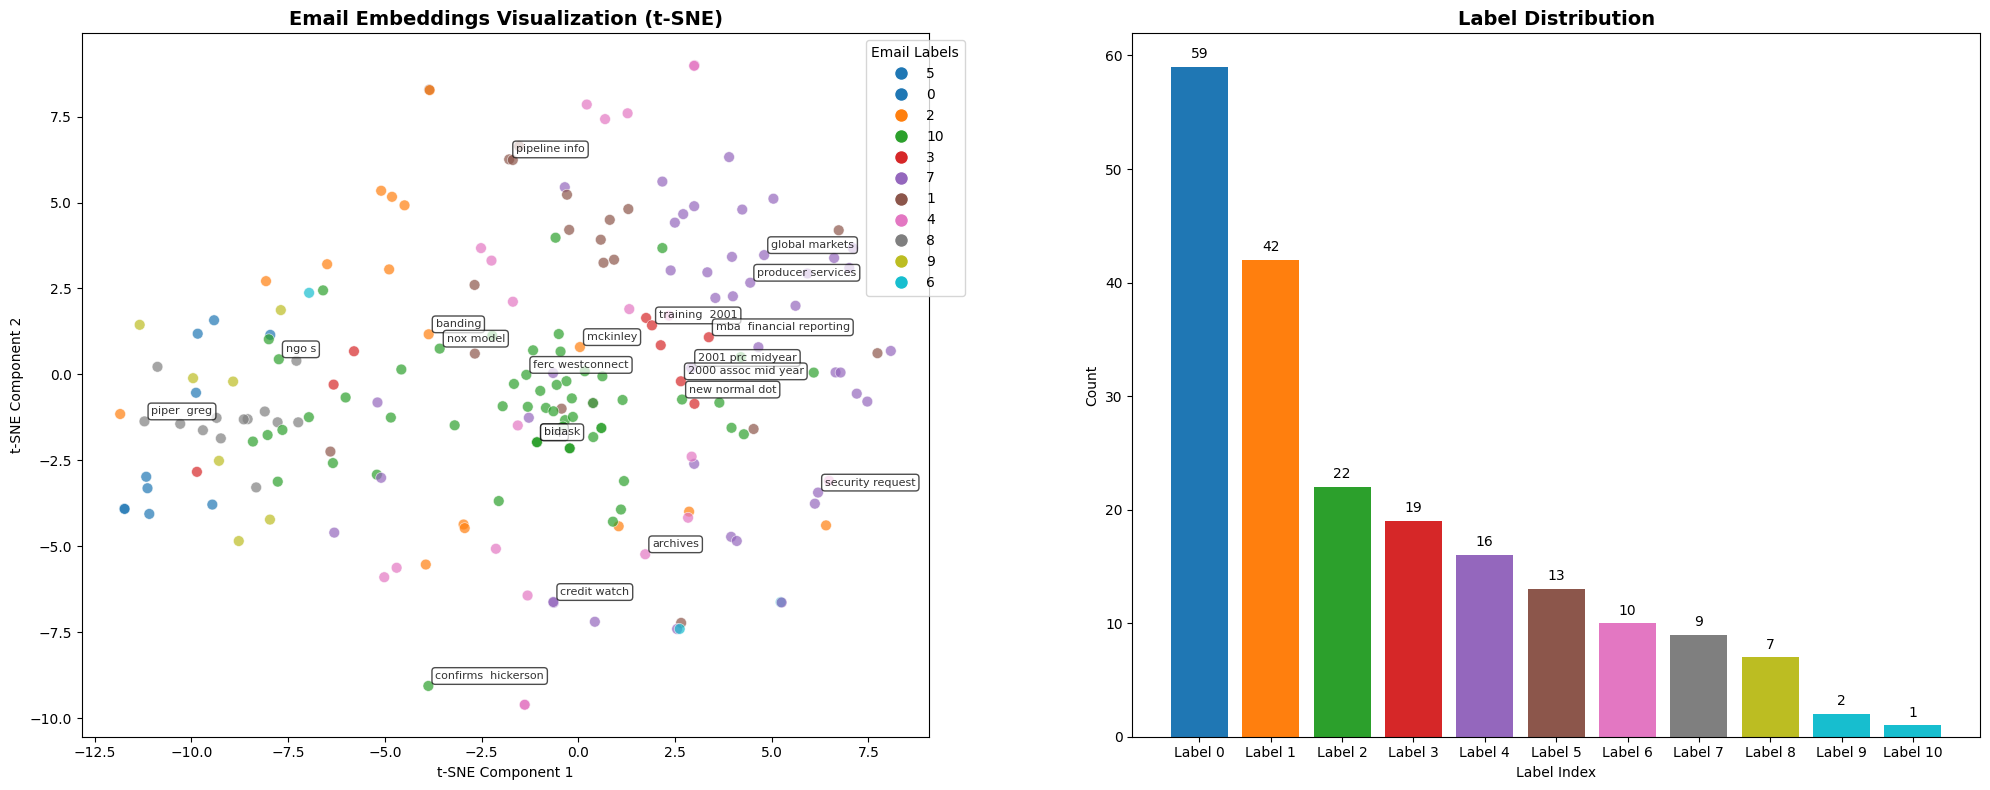


VISUALIZATION ANALYSIS SUMMARY
Total points visualized: 200
Number of unique labels: 11
Label distribution:
  Label 2: 59 emails (29.5%)
  Label 4: 42 emails (21.0%)
  Label 6: 22 emails (11.0%)
  Label 5: 19 emails (9.5%)
  Label 1: 16 emails (8.0%)
  Label 7: 13 emails (6.5%)
  Label 0: 10 emails (5.0%)
  Label 3: 9 emails (4.5%)
  Label 8: 7 emails (3.5%)
  Label 10: 2 emails (1.0%)
  Label 9: 1 emails (0.5%)
PCA explained variance: 0.717
t-SNE final loss: 0.585


In [34]:
def visualization(
    Y: np.ndarray,
    subjects: pd.Series,
    labels: pd.Series,
    label_mapping: dict,
    config: dict
) -> None:

    #Plot Styling
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    #Main Scatter Plot
    scatter = ax1.scatter(
        Y[:, 0], Y[:, 1], 
        c=labels, 
        cmap='tab10',
        s=60,
        alpha=0.7,
        edgecolors='white',
        linewidth=0.5
    )
    
    #Labels
    n_annotations = min(20, len(subjects))
    annotation_indices = np.random.choice(len(subjects), n_annotations, replace=False)
    
    for idx in annotation_indices:
        ax1.annotate(
            subjects.iloc[idx][:30] + "..." if len(subjects.iloc[idx]) > 30 else subjects.iloc[idx],
            (Y[idx, 0], Y[idx, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            alpha=0.8,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
        )
    
    ax1.set_title('Email Embeddings Visualization (t-SNE)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=plt.cm.tab10(i/len(label_mapping)), 
                                 markersize=10, label=label) 
                      for i, label in enumerate(label_mapping.keys())]
    ax1.legend(handles=legend_elements, title='Email Labels', bbox_to_anchor=(1.05, 1))
    
    # Statistical analysis plot
    label_counts = pd.Series(labels).value_counts()
    ax2.bar(range(len(label_counts)), label_counts.values, 
            color=plt.cm.tab10(np.linspace(0, 1, len(label_counts))))
    ax2.set_title('Label Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Label Index')
    ax2.set_ylabel('Count')
    ax2.set_xticks(range(len(label_counts)))
    ax2.set_xticklabels([f'Label {i}' for i in range(len(label_counts))])
    
    # Add value labels on bars
    for i, v in enumerate(label_counts.values):
        ax2.text(i, v + 0.5, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Save the figure
    output_path = os.path.join(config['figures_directory'], 'PCA_TSNE_Analysis.png')
    plt.savefig(output_path, dpi=config['dpi'], bbox_inches='tight')
    logger.info(f"Saved visualization to: {output_path}")
    
    plt.show()
    
    # Print analysis summary
    print("\n" + "="*50)
    print("VISUALIZATION ANALYSIS SUMMARY")
    print("="*50)
    print(f"Total points visualized: {len(Y)}")
    print(f"Number of unique labels: {len(label_mapping)}")
    print(f"Label distribution:")
    for label, count in label_counts.items():
        print(f"  Label {label}: {count} emails ({count/len(Y)*100:.1f}%)")
    print(f"PCA explained variance: {pca_model.explained_variance_ratio_.sum():.3f}")
    print(f"t-SNE final loss: {tsne_model.kl_divergence_:.3f}")

# Create the visualization
visualization(
    Y, sample_subjects, numeric_labels, label_mapping, CONFIG
)


CLUSTER ANALYSIS RESULTS
Silhouette Score: 0.346
Adjusted Rand Index: 0.196
Number of clusters: 11


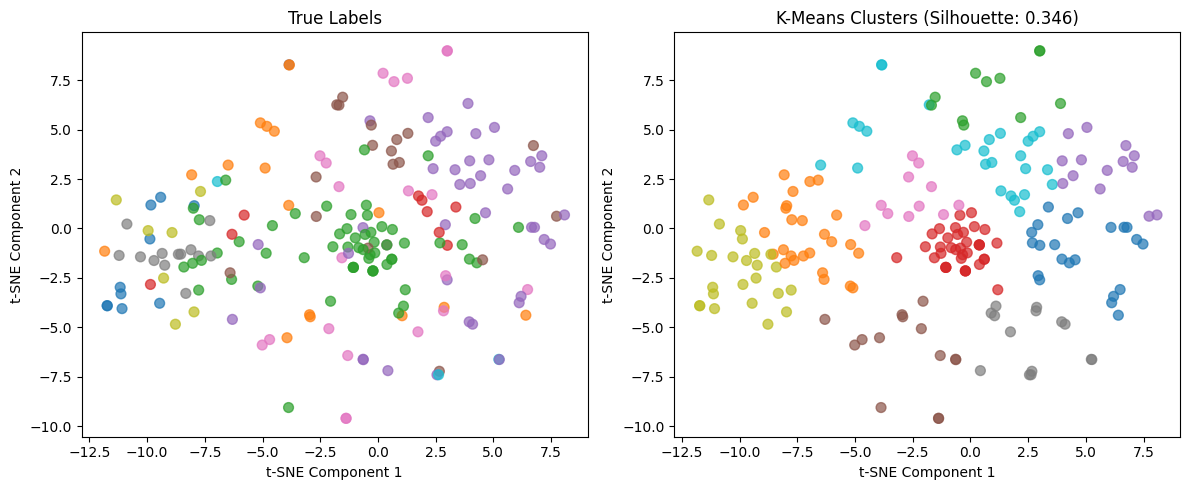

In [35]:
def cluster_analysis(Y: np.ndarray, labels: pd.Series) -> None:
    """Perform additional cluster analysis."""
    
    # K-means clustering for comparison
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, adjusted_rand_score
    
    n_clusters = len(labels.unique())
    kmeans = KMeans(n_clusters=n_clusters, random_state=CONFIG['random_state'])
    cluster_labels = kmeans.fit_predict(Y)
    
    #Metrics Calculations 
    silhouette_avg = silhouette_score(Y, cluster_labels)
    ari_score = adjusted_rand_score(labels, cluster_labels)
    
    print("\n" + "="*50)
    print("CLUSTER ANALYSIS RESULTS")
    print("="*50)
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    print(f"Adjusted Rand Index: {ari_score:.3f}")
    print(f"Number of clusters: {n_clusters}")
    
    #Plot Visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(Y[:, 0], Y[:, 1], c=labels, cmap='tab10', s=50, alpha=0.7)
    plt.title('True Labels')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    
    plt.subplot(1, 2, 2)
    plt.scatter(Y[:, 0], Y[:, 1], c=cluster_labels, cmap='tab10', s=50, alpha=0.7)
    plt.title(f'K-Means Clusters (Silhouette: {silhouette_avg:.3f})')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['figures_directory'], 'Cluster_Comparison.png'), 
                dpi=CONFIG['dpi'], bbox_inches='tight')
    plt.show()

cluster_analysis(Y, numeric_labels)